In [35]:
#import libraries


import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import pytz # for timeseries data "pytz mean python time zone"
from pymongo import MongoClient

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

from pprint import PrettyPrinter

In [36]:
pp = PrettyPrinter(indent = 3)

### Prepare Data
### Import

connect MongoDB sever and assign "air-quality" database and assign "myanmar" collection to mm. 

In [37]:
client = MongoClient(host="localhost",port=27017)
db = client["air-quality"]
mm = db["myanmar"]

### Data wrangling and Suspecting data

### Inspiration Questions

* How many cities for sites and centers for sensors are included in the myanmar collection.

* How many readings there are for each city in the myanmar collection.

* Which center are located in Yangon and Mandalay. And total reading counts in each center has.

In [38]:
result = mm.find_one({})
pp.pprint(result)

{  'AQI': 122.59,
   'Center': '7 Miles Mayangone',
   'City': 'Yangon',
   'Cumulative_cases': 0,
   'Cumulative_deaths': 0,
   'Date': datetime.datetime(2019, 10, 19, 17, 30),
   'Humidity_%': 49.64,
   'Month': 'October',
   'New_cases': 0,
   'New_deaths': 0,
   'PM10': 52.87,
   'PM1_0': 29.6,
   'PM2_5': 44.27,
   'Season': 'Rainy Season',
   'Temperature_F': 95.67,
   'Year': 2019,
   '_id': ObjectId('641b12171dfcde02aded15ca')}


In [39]:
mm.distinct('City')

['Mandalay', 'Yangon']

So we may see that there are only cities for sites are included in the myanmar collection.

In [40]:
mm.distinct('Center')

['19th Street',
 '7 Miles Mayangone',
 'Ahlone Myanmar Center for Responsible Business',
 'American Center',
 'Beca Myanmar (Outside)',
 'GEMS Condo',
 'Jefferson Center',
 'Pun Hlaing Dulwich College',
 'Star City Dulwich College',
 'Thin Gan Gyun Yangon International School (Outside)',
 'UNOPS Myanmar',
 'WWF-Myanmar',
 'YIS Grade 4 C (Inside)',
 'Yangon-HO']

So we may see that there are fourteen centers for sensors are included in the myanmar collection.

In [41]:
ygn_centers = mm.count_documents({'City': 'Yangon'})
mdy_centers = mm.count_documents({'City': 'Mandalay'})

In [42]:
print("Documents from ygn_center: ", ygn_centers)
print("Documents from mdy_center: ", mdy_centers)

Documents from ygn_center:  4366
Documents from mdy_center:  756


Above documents are readings for each city in the myanmar collection.

In [43]:
ygn_center = mm.aggregate(
    [
        {'$match' : {'City': 'Yangon'}},
        {'$group' : {'_id': '$Center', 'count':{'$count':{}}}}
    ]
)
print("Centers in Yangon :")
pp.pprint(list(ygn_center))

Centers in Yangon :
[  {'_id': 'Ahlone Myanmar Center for Responsible Business', 'count': 378},
   {'_id': 'American Center', 'count': 378},
   {'_id': 'WWF-Myanmar', 'count': 208},
   {'_id': 'Yangon-HO', 'count': 378},
   {'_id': 'YIS Grade 4 C (Inside)', 'count': 378},
   {'_id': '7 Miles Mayangone', 'count': 378},
   {'_id': 'Beca Myanmar (Outside)', 'count': 378},
   {'_id': 'UNOPS Myanmar', 'count': 378},
   {'_id': 'GEMS Condo', 'count': 378},
   {'_id': 'Thin Gan Gyun Yangon International School (Outside)', 'count': 378},
   {'_id': 'Star City Dulwich College', 'count': 378},
   {'_id': 'Pun Hlaing Dulwich College', 'count': 378}]


Twelve centers are located in Yangon and reading counts for each center.

In [44]:
mdy_center = mm.aggregate(
    [
        {'$match' : {'City': 'Mandalay'}},
        {'$group' : {'_id': '$Center', 'count':{'$count':{}}}}
    ]
)
print("Centers in Mandalay :")
pp.pprint(list(mdy_center))

Centers in Mandalay :
[  {'_id': 'Jefferson Center', 'count': 378},
   {'_id': '19th Street', 'count': 378}]


Only two centers are located in Madlay and reading counts for each center.

### Add "Wrangle" fucntion 
Now, complete the wrangle function below so that the results from the database query are read into the DataFrame df. Be sure that the index of df is the "Date" from the results.

In [71]:
def wrangle(collection):
    
    result = mm.find(
        {'City': 'Yangon'},
        projection={'_id': 0, 'City': 1, 'Center': 1, 'Season': 1, 'PM2_5': 1, 'Date': 1, 'Year' : 1},
    )
    
    
    #"df_ygn" is for Yangon City
    df_ygn = pd.DataFrame(result).set_index('Date')
    
    
    #localize timezone
    df_ygn.index = df_ygn.index.tz_localize("UTC").tz_convert("Asia/Yangon")
    
    #remove outliner
    df_ygn = df_ygn[df_ygn["PM2_5"] < 3000]
    
    #resample to "1W" window
    df_ygn = df_ygn["PM2_5"].resample("1W").mean().to_frame()
    
    #create a new column for lagging feature
    df_ygn["PM2_5.S1"] = df_ygn["PM2_5"].shift(1)
    df_ygn.dropna(inplace=True)


    return df_ygn

In [72]:
df_ygn = wrangle(mm)
print(df_ygn.shape)
df_ygn.tail()

(54, 2)


,PM2_5,PM2_5.S1
Date,,
2020-10-04 00:00:00+06:30,9.670952,4.458333
2020-10-11 00:00:00+06:30,14.444405,9.670952
2020-10-18 00:00:00+06:30,8.324762,14.444405
2020-10-25 00:00:00+06:30,7.620952,8.324762
2020-11-01 00:00:00+06:30,13.501944,7.620952


the DatetimeIndex for df_ygn is localized to the correct timezone.

In [49]:
df_ygn.index[:5]

DatetimeIndex(['2019-10-19 17:30:00', '2019-10-20 17:30:00',
               '2019-10-21 17:30:00', '2019-10-22 17:30:00',
               '2019-10-23 17:30:00'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [47]:
df_ygn.index.tz_localize("UTC")[:5]

DatetimeIndex(['2019-10-19 17:30:00+00:00', '2019-10-20 17:30:00+00:00',
               '2019-10-21 17:30:00+00:00', '2019-10-22 17:30:00+00:00',
               '2019-10-23 17:30:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', freq=None)

In [48]:
df_ygn.index.tz_localize("UTC").tz_convert("Asia/Yangon")[:5]

DatetimeIndex(['2019-10-20 00:00:00+06:30', '2019-10-21 00:00:00+06:30',
               '2019-10-22 00:00:00+06:30', '2019-10-23 00:00:00+06:30',
               '2019-10-24 00:00:00+06:30'],
              dtype='datetime64[ns, Asia/Yangon]', name='Date', freq=None)

In [62]:
# Check your work
assert df_ygn.index.tzinfo == pytz.timezone("Asia/Yangon")

### Explore Data and Visualization



In [51]:
df_ygn["PM2_5"].describe()

count    4366.000000
mean       28.571748
std        25.739374
min         0.000000
25%         6.810000
50%        28.920000
75%        44.442500
max       163.680000
Name: PM2_5, dtype: float64

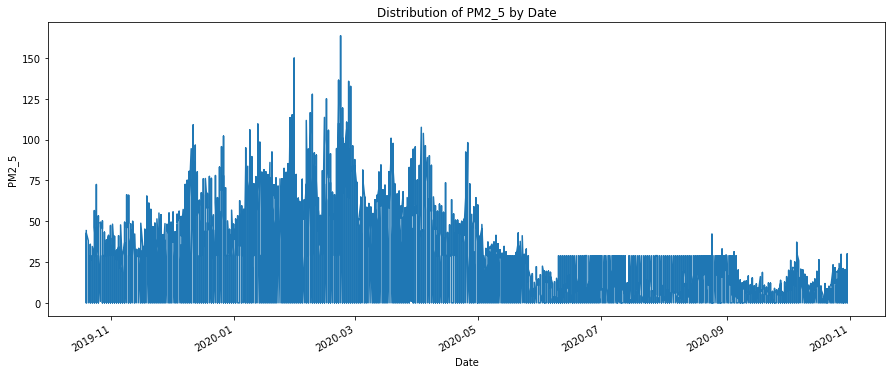

In [52]:
fig,ax =  plt.subplots(figsize=(15,6))
df_ygn["PM2_5"].plot(
    ax=ax,
    ylabel="PM2_5",
    title="Distribution of PM2_5 by Date"
    
);
fig.savefig('before.png')

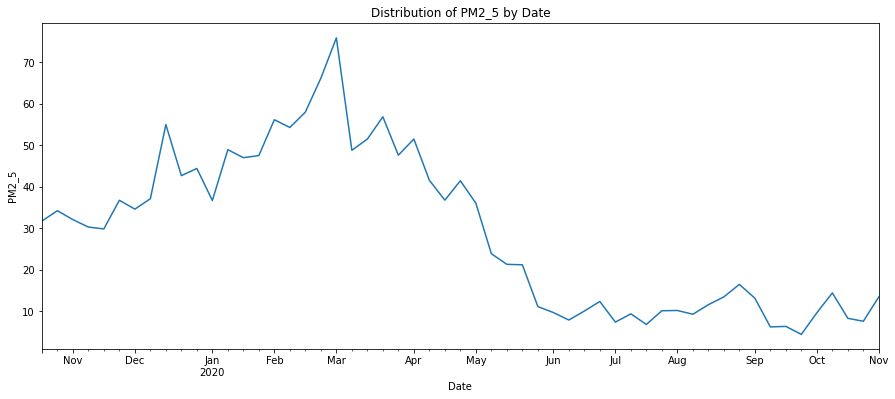

In [63]:
#After resample
fig,ax =  plt.subplots(figsize=(15,6))
df_ygn["PM2_5"].plot(
    ax=ax,
    ylabel="PM2_5",
    title="Distribution of PM2_5 by Date"
    
);
fig.savefig('After.png')

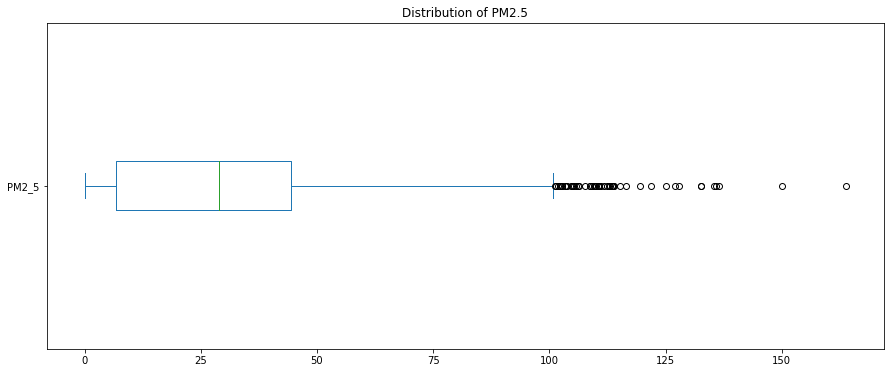

In [53]:
fig, ax = plt.subplots(figsize=(15, 6))

df_ygn["PM2_5"].plot(
    kind="box",
    vert = False,
    title = "Distribution of PM2.5"
)
fig.savefig('box.png')

In [ ]:
#df_ygn[df_ygn["PM2_5"] < 500].head()

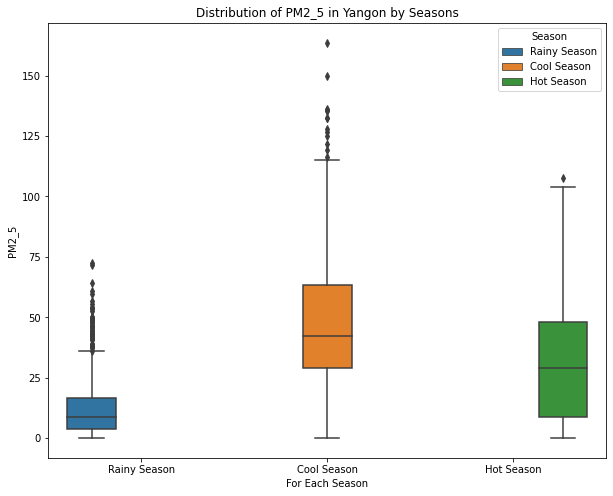

In [54]:
season = plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Season', y='PM2_5', data=df_ygn, hue="Season")
fig.set_xlabel("For Each Season")
fig.set_ylabel("PM2_5")
fig.set_title("Distribution of PM2_5 in Yangon by Seasons")

season.savefig('season.png')

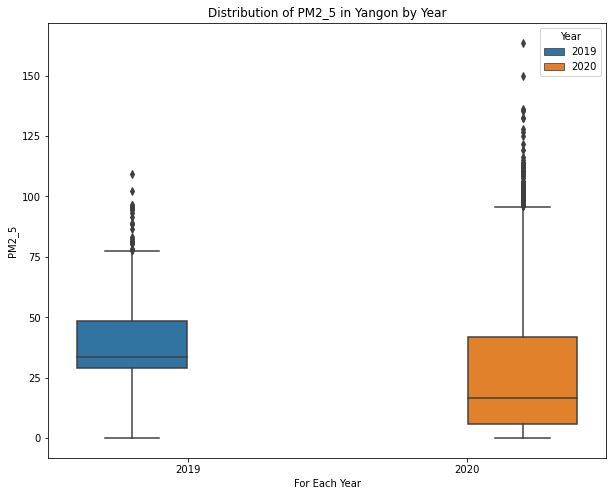

In [55]:
season = plt.figure(figsize=(10,8))
fig = sns.boxplot(x='Year', y='PM2_5', data=df_ygn, hue="Year")
fig.set_xlabel("For Each Year")
fig.set_ylabel("PM2_5")
fig.set_title("Distribution of PM2_5 in Yangon by Year")

season.savefig('year.png')

One way to measure a person’s fitness is to measure their body fat percentage. Most guidelines expect a difference between body fat for men and for women. (For more on this data, see the two-sample t-test page.) The variable Body Fat is continuous, so a box plot is an appropriate method for displaying the distribution of the data. Figure 9 shows separate side-by-side box plots for men and women.

From this graph, you can see that men have a lower median body fat than women. You can also see that the ranges for men and women overlap. The data for men has more skewness than the data for women. Neither group has outliers. With JMP, you could add means diamonds, a line for each mean, and annotations to these box plots


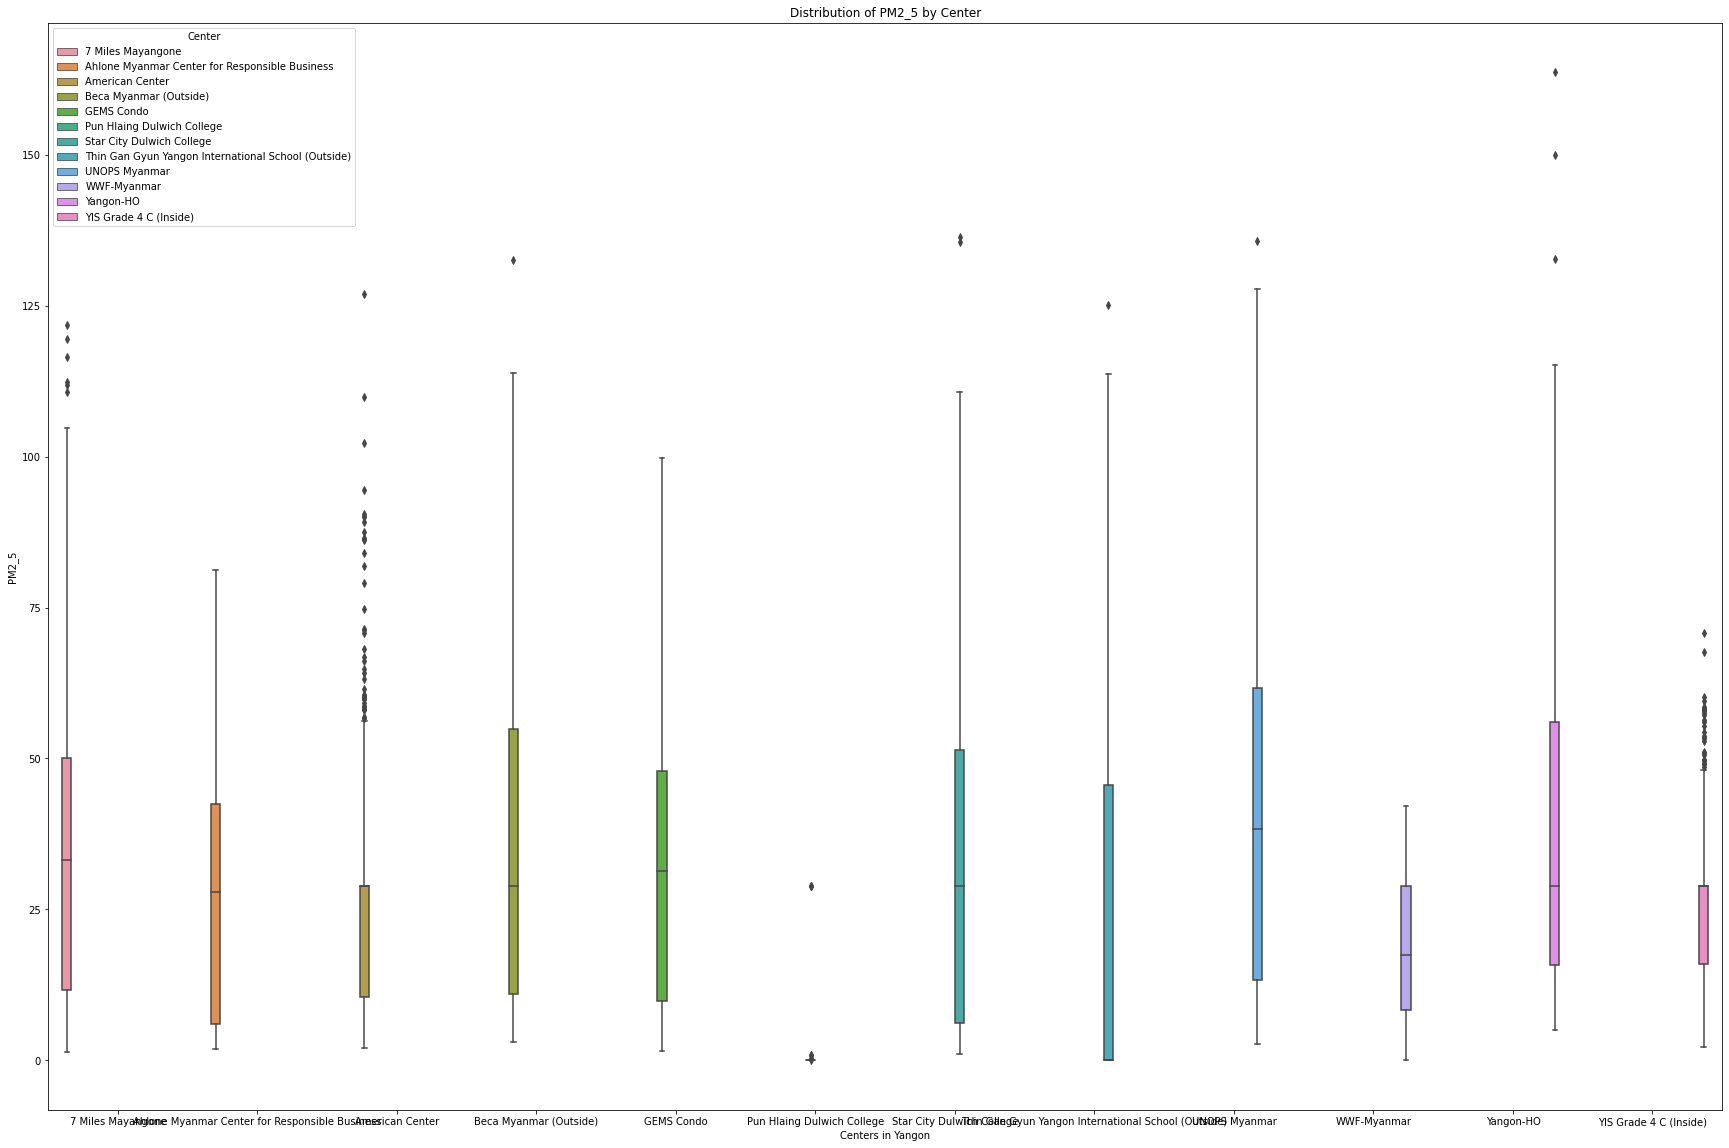

In [56]:
season = plt.figure(figsize=(30,20))
fig = sns.boxplot(x='Center', y='PM2_5', data=df_ygn, hue="Center")
fig.set_xlabel("Centers in Yangon")
fig.set_ylabel("PM2_5")
fig.set_title("Distribution of PM2_5 by Center")

season.savefig('center.png')

In [57]:
df_ygn["PM2_5"].resample("1W").mean().isnull().sum()

0

In [58]:
df_ygn["PM2_5"].resample("1H").mean().to_frame().head()

,PM2_5
Date,
2019-10-19 17:00:00,31.755455
2019-10-19 18:00:00,NaN
2019-10-19 19:00:00,NaN
2019-10-19 20:00:00,NaN
2019-10-19 21:00:00,NaN


Plot the rolling average of the "PM2_5" readings in df_ygn. Use a window size of 168 (the number of hours in a week)

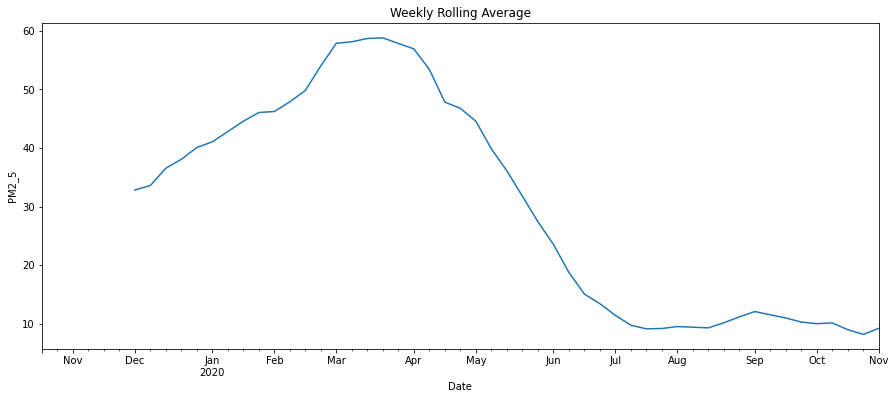

In [65]:
#After rolling our data
fig,ax =  plt.subplots(figsize=(15,6))

df_ygn["PM2_5"].rolling(7).mean().plot(
                                        ax=ax,
                                        ylabel="PM2_5",
                                        title="Weekly Rolling Average"
    
);
fig.savefig('rolling.png')

create a column called "PM2_5.S1" that contains the mean"PM2_5" reading from the previous week.

In [70]:
df_ygn["PM2_5.S1"] = df_ygn["PM2_5"].shift(1)
df_ygn["PM2_5.S1"].head()

Date
2019-10-20 00:00:00+06:30          NaN
2019-10-27 00:00:00+06:30    31.755455
2019-11-03 00:00:00+06:30    34.255455
2019-11-10 00:00:00+06:30    32.117662
2019-11-17 00:00:00+06:30    30.322987
Freq: W-SUN, Name: PM2_5.S1, dtype: float64

In [73]:
df_ygn.corr()

,PM2_5,PM2_5.S1
PM2_5,1.000000,0.934782
PM2_5.S1,0.934782,1.000000


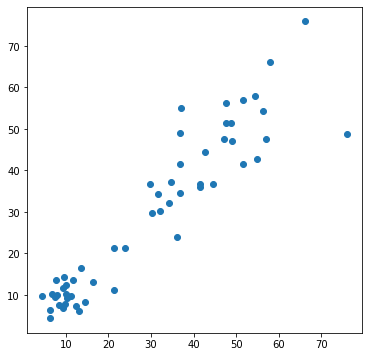

In [75]:
#Create a scatter plot that shows PM 2.5 mean reading for each week as a function of the mean reading from the previous week
fig, ax  = plt.subplots(figsize=(6,6))

ax.scatter(
    x=df_ygn["PM2_5.S1"],
    y=df_ygn["PM2_5"],
    
)


### Split

Split the DataFrame df into the feature matrix X and the target vector y. Your target is "PM2_5"

In [76]:
target = "PM2_5"
y = df_ygn[target]
X = df_ygn.drop(columns=target)

In [77]:
y.head()

Date
2019-10-27 00:00:00+06:30    34.255455
2019-11-03 00:00:00+06:30    32.117662
2019-11-10 00:00:00+06:30    30.322987
2019-11-17 00:00:00+06:30    29.871948
2019-11-24 00:00:00+06:30    36.776234
Freq: W-SUN, Name: PM2_5, dtype: float64

Split X and y into training and test sets. The first 80% of the data should be in your training set. The remaining 20% should be in the test set.

In [78]:
int(len(X) * 0.8)

43

In [79]:
cutoff = int(len(X) * 0.8)

In [81]:
X.iloc[:cutoff].head()

,PM2_5.S1
Date,
2019-10-27 00:00:00+06:30,31.755455
2019-11-03 00:00:00+06:30,34.255455
2019-11-10 00:00:00+06:30,32.117662
2019-11-17 00:00:00+06:30,30.322987
2019-11-24 00:00:00+06:30,29.871948


In [102]:
#for training data we take 80%
cutoff = int(len(X) * 0.8)

X_train,y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test,y_test = X.iloc[cutoff:], y.iloc[cutoff:]

## Build Model
### Baseline
Calculate the baseline mean absolute error for model.

In [103]:
y_mean = y_train.mean()
y_mean

34.02802501761804

In [104]:
y_pred_baseline = [y_mean] * len(X_train)
mae_baselinea= mean_absolute_error(y_train,y_pred_baseline)

print("Mean PM2_5 Reading:", round(y_train.mean(), 2))
print("Baseline Mae:", round(mae_baselinea, 2))

Mean PM2_5 Reading: 34.03
Baseline Mae: 15.7


### Iterate

Instantiate a LinearRegression model named model, and fit it to training data

In [105]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

### Evalute
Calculate the training and test mean absolute error for mode

In [106]:
training_mae = mean_absolute_error(y_train, model.predict(X_train))   #training

test_mae = mean_absolute_error(y_test, model.predict(X_test))   # testing
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 5.3
Test MAE: 3.66


### Communicate Results
Extract the intercept and coefficient from your model

In [107]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)

print(f"PM2_5 = {intercept} + ({coefficient} * PM2_5.S1)")

PM2_5 = 1.79 + ([0.93] * PM2_5.S1)


In [108]:
df_pred_test = pd.DataFrame(
    {
    'y_test' : y_test,
    'y_pred' : model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
Date,,
2020-08-23 00:00:00+06:30,13.492143,12.630525
2020-08-30 00:00:00+06:30,16.503214,14.396532
2020-09-06 00:00:00+06:30,13.176429,17.210771
2020-09-13 00:00:00+06:30,6.256071,14.101456
2020-09-20 00:00:00+06:30,6.378452,7.633479


In [109]:
fig = px.line(df_pred_test,labels={"value":"PM2_5"})
fig.show()

Perform walk-forward validation for your model for the entire test set y_test. Store your model's predictions in the Series y_pred_wfv